In [1]:
import seaborn as sns
import multiprocessing as mp
from math import factorial
import itertools
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from wavelet import *
from run_tsne import *
from density_map import *
from embedding_z import *
import matplotlib.gridspec as grd
from scipy.stats import gaussian_kde
%matplotlib notebook

In [2]:
filepath = "data/rat_data_short.txt"
data = np.loadtxt(filepath)

In [3]:
# parse data, find segment lengths and joint angles
HeadF = data[:,0:3]
HeadB = data[:,3:6]
HeadL = data[:,6:9]
SpineF = data[:,9:12]
SpineM = data[:,12:15]
SpineL = data[:,15:18]
Offset1 = data[:,18:21]
Offset2 = data[:,21:24]
HipL = data[:,24:27]
HipR = data[:,27:30]
ElbowL = data[:,30:33]
ArmL = data[:, 33:36]
ShoulderL = data[:, 36:39]
ShoulderR = data[:, 39:42]
ElbowR = data[:, 42:45]
ArmR = data[:,45:48]
KneeR = data[:,48:51]
KneeL = data[:,51:54]
ShinL = data[:, 54:57]
ShinR = data[:, 57:60]



In [4]:
def joint_angle(x1 = np.array([]), x2 = np.array([]), x3 = np.array([])):
# x1, x2, x3 are your first, second, third points
    angle = np.zeros(x1.shape[0])
    for i in range(x1.shape[0]):
        angle[i] = np.arccos(np.dot((x1[i]-x2[i]), (x3[i]-x2[i])) / (np.linalg.norm(x1[i]-x2[i]) * np.linalg.norm(x3[i]-x2[i])))            
    return angle

def calculate_combinations(n, r):
    return factorial(n) // factorial(r) // factorial(n-r)

def parse_body_parts(body_part):
# a body part contains all relevant tracking data for a certain body part
# e.g. for Head, is HeadF, HeadB, HeadL and SpineF
    count1 = 0
    count2 = 0
    Segs = np.zeros((calculate_combinations(len(body_part),2),np.shape(body_part[0])[0]))
    Joint_angles = np.zeros((calculate_combinations(len(body_part),3),np.shape(body_part[0])[0])) 
    for ele in itertools.combinations(body_part,2):
        Segs[count1] = np.linalg.norm(ele[0]-ele[1], axis = 1)
        count1 += 1
    for ele in itertools.combinations(body_part,3):
        Joint_angles[count2] = joint_angle(ele[0], ele[1], ele[2])
        count2 += 1
    return Segs,Joint_angles

Head_seg,Head_angle = parse_body_parts((HeadF,HeadB,HeadL,SpineF))
print('Done HEAD segment lengths and joint angles')
Body_seg,Body_angle = parse_body_parts((SpineF,SpineM,SpineL,Offset1,Offset2))
print('Done BODY segment lengths and joint angles')
LimbL_seg,LimbL_angle = parse_body_parts((ElbowL,ArmL,ShoulderL,SpineF))
print('Done LIMBL segment lengths and joint angles')
LimbR_seg,LimbR_angle = parse_body_parts((ElbowR,ArmR,ShoulderR,SpineF))
print('Done LIMBR segment lengths and joint angles')
LegL_seg,LegL_angle = parse_body_parts((HipL,KneeL,ShinL,SpineL))
print('Done LEGL segment lengths and joint angles')
LegR_seg,LegR_angle = parse_body_parts((HipR,KneeR,ShinR,SpineL))
print('Done LEGR segment lengths and joint angles')

Done HEAD segment lengths and joint angles


/Users/jinqian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Done BODY segment lengths and joint angles
Done LIMBL segment lengths and joint angles
Done LIMBR segment lengths and joint angles
Done LEGL segment lengths and joint angles
Done LEGR segment lengths and joint angles


In [5]:
np.shape(np.transpose(Head_seg[0]))

(300000,)

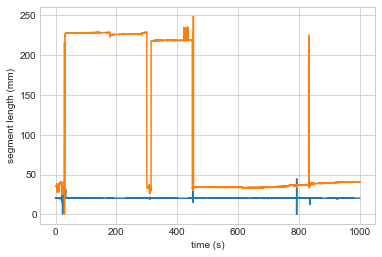

In [6]:
# plot segment lengths:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.plot(np.linspace(0,1000,300000), Head_seg[0], label = 'HeadF - HeadB')
    plt.plot(np.linspace(0,1000,300000), Body_seg[0], label = 'SpineF - SpineM') 
    plt.ylabel('segment length (mm)')
    plt.xlabel('time (s)')
    plt.savefig('./plots/segment_lengths.png')
    plt.show()

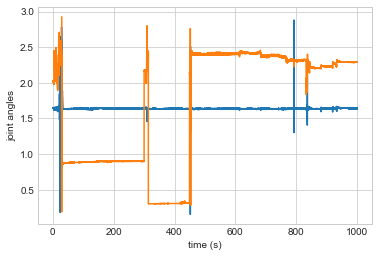

In [7]:
# plot joint angles:

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.plot(np.linspace(0,1000,300000), Head_angle[0], label = 'HeadF - HeadB - HeadL')
    plt.plot(np.linspace(0,1000,300000), Body_angle[0], label = 'SpineF - SpineM - SpineL') 
    plt.ylabel('joint angles')
    plt.xlabel('time (s)')
    plt.savefig('./plots/joint_angles.png')
    plt.show()

In [8]:
# combine all data in one data set
All_seg_angle = np.zeros((Head_seg.shape[0]+Head_angle.shape[0]+
                          Body_seg.shape[0]+Body_angle.shape[0]+LimbL_seg.shape[0]+LimbL_angle.shape[0]+
                          LimbR_seg.shape[0]+LimbR_angle.shape[0]+LegL_seg.shape[0]+LegL_angle.shape[0]+
                          LegR_seg.shape[0]+LegR_angle.shape[0], data.shape[0]))
print(np.shape(All_seg_angle)[0])
All_seg_angle[:Head_seg.shape[0]] = Head_seg
temp = Head_seg.shape[0]
All_seg_angle[temp:temp+Head_angle.shape[0]] = Head_angle
temp += Head_angle.shape[0]
All_seg_angle[temp:temp+Body_seg.shape[0]] = Body_seg
temp += Body_seg.shape[0]
All_seg_angle[temp:temp+Body_angle.shape[0]] = Body_angle
temp += Body_angle.shape[0]
All_seg_angle[temp:temp+LimbL_seg.shape[0]] = LimbL_seg
temp += LimbL_seg.shape[0]
All_seg_angle[temp:temp+LimbL_angle.shape[0]] = LimbL_angle
temp += LimbL_angle.shape[0]
All_seg_angle[temp:temp+LimbR_seg.shape[0]] = LimbR_seg
temp += LimbR_seg.shape[0]
All_seg_angle[temp:temp+LimbR_angle.shape[0]] = LimbR_angle
temp += LimbR_angle.shape[0]
All_seg_angle[temp:temp+LegL_seg.shape[0]] = LegL_seg
temp += LegL_seg.shape[0]
All_seg_angle[temp:temp+LegL_angle.shape[0]] = LegL_angle
temp += LegL_angle.shape[0]
All_seg_angle[temp:temp+LegR_seg.shape[0]] = LegR_seg
temp += LegR_seg.shape[0]
All_seg_angle[temp:temp+LegR_angle.shape[0]] = LegR_angle

print(All_seg_angle[6])

70
[1.64822657 1.64851754 1.64813514 ... 1.64207995 1.64308366 1.64415663]


In [9]:
# Running Wavelet Transform


numPeriods = 75 #set number of period
omega0 = 5
samplingFreq = 300.
dt = 1/samplingFreq
# set frequency 
minF = 1.  
maxF = 150.
minT = 1/maxF; maxT = 1/minF;
Ts = []; f = []
for i in range(numPeriods):
    Ts.append(minT*2**(i*np.log(maxT/minT)/(np.log(2)*(numPeriods-1))))
f = [1/i for i in Ts]
f.reverse()

numModes = All_seg_angle.shape[0]   #running wavelet transform on first 20 eigenmodes


N = np.shape(All_seg_angle)[1]  #number of time points
amp = np.zeros((N, numModes*numPeriods))  

# multiprocess 
pool = mp.Pool(processes=70)
results = pool.map(fastWavelet_morlet_convolution_parallel,
                   itertools.izip(itertools.chain(All_seg_angle[:numModes]),
                                  itertools.repeat(f), itertools.repeat(omega0), itertools.repeat(dt),itertools.count(1)))
pool.close()
pool.join()
              
for i, result in zip(range(numModes), results):
    amp[:,(i)*numPeriods:(i+1)*numPeriods] = np.transpose(result)

#wavelet = amp
#np.savetxt('wavelet.out', wavelet)

Calculating morlet wavelet transform of eigenmodes 1......
Calculating morlet wavelet transform of eigenmodes 2......
Calculating morlet wavelet transform of eigenmodes 3......
Calculating morlet wavelet transform of eigenmodes 4......
Calculating morlet wavelet transform of eigenmodes 5......
Calculating morlet wavelet transform of eigenmodes 6......
Calculating morlet wavelet transform of eigenmodes 7......
Calculating morlet wavelet transform of eigenmodes 8......
Calculating morlet wavelet transform of eigenmodes 9......
Calculating morlet wavelet transform of eigenmodes 10......
Calculating morlet wavelet transform of eigenmodes 11......
Calculating morlet wavelet transform of eigenmodes 12......
Calculating morlet wavelet transform of eigenmodes 13......
Calculating morlet wavelet transform of eigenmodes 14......
Calculating morlet wavelet transform of eigenmodes 15......
Calculating morlet wavelet transform of eigenmodes 16......
Calculating morlet wavelet transform of eigenmode

In [10]:
where_are_NaNs = np.isnan(amp)
where_are_Infs = np.isinf(amp)
amp[where_are_NaNs] = 1e-12
amp[where_are_Infs] = 1e-12
amp[amp == 1e-12] = 1e-6

In [ ]:
print(amp[np.isnan(amp)])

In [ ]:
fig = plt.figure()
time = [i * dt for i in range(N)]
T, F = np.meshgrid(time,f)

gs = grd.GridSpec(2, 2,  width_ratios=[20,1], wspace=0.1,hspace=0.4)

# image plot
ax1 = plt.subplot(gs[0])
a = np.transpose(amp[:,(0)*numPeriods:numPeriods+(0)*numPeriods])
im = ax1.pcolormesh(T,F,a,cmap = 'CMRmap_r', norm=matplotlib.colors.LogNorm(vmin=a.min(), vmax=a.max()))
plt.title('wavelet transform of segment length HeadF-HeadB ')
plt.ylabel('frequency')
ax1.set_yscale('log')

colorAx = plt.subplot(gs[1])
cb = plt.colorbar(im, cax = colorAx)
cb.set_label('RWU')

ax2 = plt.subplot(gs[2])
a = np.transpose(amp[:,(6)*numPeriods:numPeriods+(6)*numPeriods])
im = ax2.pcolormesh(T,F,a,cmap = 'CMRmap_r', norm=matplotlib.colors.LogNorm(vmin=a.min(), vmax=a.max()))
plt.title('wavelet transform of joint angle HeadF-HeadB-HeadL')
plt.xlabel('time')
plt.ylabel('frequency')
ax2.set_yscale('log')

colorAx = plt.subplot(gs[3])
cb = plt.colorbar(im, cax = colorAx)
cb.set_label('RWU')

plt.savefig('./plots/wavelet.png')
plt.show()


In [ ]:
training_set = 5000 #set size of training set
batch_index = np.loadtxt('./data/training_batch_index.txt')
#np.savetxt('./data/training_batch_index.txt', batch_index)
motion_map = np.zeros((20000,2))
for i in range(1,4):
    training_batch = amp[batch_index[i*5000:(i+1)*5000],:]
    results = tsne(training_batch, 2,perplexity = 30)
    motion_map[i*5000:(i+1)*5000] = results
    np.savetxt('./data/motion_map_{}.txt'.format(i), results)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 5000...
Computing P-values for point 500 of 5000...
Computing P-values for point 1000 of 5000...
Computing P-values for point 1500 of 5000...
Computing P-values for point 2000 of 5000...
Computing P-values for point 2500 of 5000...
Computing P-values for point 3000 of 5000...
Computing P-values for point 3500 of 5000...
Computing P-values for point 4000 of 5000...
Computing P-values for point 4500 of 5000...
Mean value of sigma: 0.222674
Iteration 0: error is 26.454924
Iteration 10: error is 24.738898
Iteration 20: error is 23.092187
Iteration 30: error is 19.104450
Iteration 40: error is 16.894266
Iteration 50: error is 15.758950
Iteration 60: error is 15.164553
Iteration 70: error is 14.815600
Iteration 80: error is 14.557373
Iteration 90: error is 14.355255
Iteration 100: error is 14.175625
Iteration 110: error is 1.900770
Iteration 120: error is 1.762985
Iteration 130: error is 1.6

Mean value of sigma: 0.220479
Iteration 0: error is 26.492588
Iteration 10: error is 24.730456
Iteration 20: error is 22.903474
Iteration 30: error is 18.834702
Iteration 40: error is 16.678216
Iteration 50: error is 15.581671
Iteration 60: error is 14.975378
Iteration 70: error is 14.651744
Iteration 80: error is 14.441936
Iteration 90: error is 14.258674
Iteration 100: error is 14.086407
Iteration 110: error is 1.895912
Iteration 120: error is 1.769817
Iteration 130: error is 1.662700
Iteration 140: error is 1.562865
Iteration 150: error is 1.470209
Iteration 160: error is 1.386242
Iteration 170: error is 1.311188
Iteration 180: error is 1.244468
Iteration 190: error is 1.185146
Iteration 200: error is 1.132357
Iteration 210: error is 1.085181
Iteration 220: error is 1.042859
Iteration 230: error is 1.004761
Iteration 240: error is 0.970318
Iteration 250: error is 0.939055
Iteration 260: error is 0.910588
Iteration 270: error is 0.884595
Iteration 280: error is 0.860785
Iteration 290

In [ ]:
x = motion_map[:,0]
y = motion_map[:,1]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x,y, c=z, s=1, edgecolor='')
plt.xlim([motion_map.min(),motion_map.max()])
plt.ylim([motion_map.min(),motion_map.max()])
plt.colorbar()
plt.title('scatter plot of training set')
plt.savefig('./plots/motion_map_scatter.png')

In [ ]:
#density map
#motion_map = np.loadtxt('./data/motion_map.txt')
plot_density_map(motion_map, beta = 50,resolution = 1000)



In [ ]:


def findListKLDivergences(data,data2):

    logData = np.log(data)

    entropies = -np.sum(data*logData, axis = 1)
  
    logData2 = np.log(data2)  

    D = np.dot(-data, np.transpose(logData2))
    
    D = D - entropies[:,None]
        
    D = D / np.log(2)
    
    return D

def returnCorrectSigma_sparse(ds,perplexity,tol,maxNeighbors):
    s = np.shape(ds)   
    
    highGuess = np.max(ds)
    lowGuess = 1e-10

    sigma = 0.5*(highGuess + lowGuess)
    sortIdx = np.argsort(ds)
    ds = ds[sortIdx[0:maxNeighbors]]
    p = np.exp(-0.5*(ds**2)/(sigma**2))
    p = p/np.sum(p)
    idx = p>0
    H = np.sum(-p[idx]*np.log(p[idx])/np.log(2), axis = 0)
    P = 2**H
    
    if np.abs(P-perplexity) < tol:
        test = False
    else:
        test = True
    
    while test:
        
        if P > perplexity:
            highGuess = sigma
        else:
            lowGuess = sigma
    
        
        sigma = 0.5*(highGuess + lowGuess)
        
        p = np.exp(-0.5*(ds**2)/(sigma**2))
        p = p/np.sum(p)
        idx = p>0
        H = np.sum(-p[idx]*np.log(p[idx])/np.log(2), axis = 0)
        P = 2**H
        
        if abs(P-perplexity) < tol:
            test = False
            
    #if s[0] == 1:
    #    p = sp.sparse.coo_matrix((p,([0*maxNeighbors],sortIdx[0:maxNeighbors])),shape = (s[0],s[1]))
    #else:
    #   p = sp.sparse.coo_matrix((p,(sortIdx[0:maxNeighbors],[0*maxNeighbors])),shape = (s[0],s[1]))
        
    return sigma, p


def findListDistances(x,data2):
    D = np.zeros(data2.shape[0])
    for j in range(data2.shape[0]):
        D[j] = (x[0] - data2[j,0])**2+(x[1] -data2[j,1])**2 
    return D

def embedding_Z (data, training_data, motion_map, batchSize, perplexity = 32,sigmaTolerance = 1e-5,maxNeighbors = 200):
    N = data.shape[0]
    zValues = np.zeros((N,2))
    zGuesses = np.zeros((N,2))
    zCosts = np.zeros((N,1))
    batches = int(round(N/batchSize))
    inConvHull = np.zeros((N,1))
    meanMax = np.zeros((N,1))
    
    for j in range(batches):
        print('processing batch {} out of {}...').format(j,batches)
        idx = np.arange(j*batchSize, (j+1)*batchSize)
        current_guesses = np.zeros((idx.shape[0],2))
        current = np.zeros((idx.shape[0],2))
        currentData = data[idx,:]
        tCosts = np.zeros(idx.shape[0])
        current_poly = np.zeros((idx.shape[0],1))
        
        D2 = findListKLDivergences(currentData,training_data)
        current_meanMax = np.zeros((idx.shape[0],1))
        
        for i in range(idx.shape[0]):
            useless, p = returnCorrectSigma_sparse(D2[i,:],perplexity,sigmaTolerance,maxNeighbors)
            idx2 = np.argwhere(p>0)
            z = motion_map[idx2, :]
            maxidx = np.argmax(p)
            a = np.sum(z*p[idx2,None], axis = 0)
            guesses = np.concatenate((a, [motion_map[maxidx]]),axis = 0)

            b = np.zeros((2,2))
            c = np.zeros((2,1))
            flags = np.zeros((2,1))
            z = np.reshape(z,(-1,2))
            q = sp.spatial.ConvexHull(z)
     
            q = z[q.vertices,:]
    
        
            calculateKLCost = lambda x: np.log(np.sum(1/(1+findListDistances(x,z)))) + np.sum(p[p>0]*np.log(1+findListDistances(x,z)))
            b[0,:], c[0] = sp.optimize.fmin(calculateKLCost, guesses[0,:])
            b[1,:], c[1] = sp.optimize.fmin(calculateKLCost, guesses[1,:])
            print(guesses)
            p = matplotlib.path.Path(q)
            polyIn = p.contains_points(b)
    
            polyIn[polyIn == True] = 1
            polyIn[polyIn == False] = 0
            
            if np.sum(polyIn) > 0:
                pp = np.argwhere(polyIn!= 0)
                mI = np.argmin(c[polyIn==1])
                mI = pp[mI]
                current_poly[i] = True
            else:
                mI = np.argmin(c)
                current_poly[i] = False

            current_guesses[i,None] = guesses[mI,:]
            current[i,:] = b[mI,:]
            tCosts[i] = c[mI]
            current_meanMax[i] = mI
        
        zGuesses[idx,:] = current_guesses
        zValues[idx,:] = current
        inConvHull[idx] = current_poly
        meanMax[idx] = current_meanMax
    
    zValues[np.argwhere(inConvHull==False)] = zGuesses[np.argwhere(inConvHull == False)]
    
    return zValues

In [ ]:
embedding_values = embedding_Z (amp[:30000], amp[batch_index,:], motion_map, 1000)

In [ ]:
# animate time sequential embedding values on motion map
def update_plot(i):
    scat.set_offsets(embedding_values[i])
    return scat,

numframes = 100
(X, Y) = embedding_values[0]
fig, ax = plt.subplots()
y = motion_map
rangeVals = [int(-y.max()), int(y.max())]
sigma = y.max()/15
XX, YY, density = density_map(y, sigma, rangeVals, 1000)
im = ax.pcolormesh(XX, YY, density, cmap = 'CMRmap_r')
scat = ax.scatter(X, Y, s = 20)
ax.set_xlim(int(-y.max()), int(y.max()))
ax.set_ylim(int(-y.max()), int(y.max()))

ani = animation.FuncAnimation(fig, update_plot, frames=xrange(numframes))
FFwriter = animation.FFMpegWriter(fps=15, extra_args=['-vcodec', 'libx264'])
ani.save('./plots/embedding_plot.mp4', writer=FFwriter)

In [ ]:
fig = plt.figure(figsize = (15,3))

plt.plot(range(10000,10100),embedding_values[:,0], label = 'embedding value [0]')
plt.plot(range(10000,10100),embedding_values[:,1], label = 'embedding value [1]')
plt.show()